# Quantum Neural Networks

This notebook demonstrates the different generic quantum neural network (QNN) implementations provided in Qiskit Machine Learning.
The networks are meant as application-agnostic computational units that can be used for many different use cases. 
Depending on the application, a particular type of network might more or less suitable and might require to be set up in a particular way.
The following different available neural networks will now be discussed in more detail:

1. `NeuralNetwork`: The interface for neural networks. This is an abstract class.
2. `EstimatorQNN`: A network based on the evaluation of quantum mechanical observables.
3. `SamplerQNN`: A network based on the samples resulting from measuring a quantum circuit.

Each implementation, `EstimatorQNN` and `SamplerQNN`, takes in an optional instance of the corresponding Qiskit primitive, namely `BaseEstimator` and `BaseSampler`. The latter two define two interfaces of the primitives. Qiskit provides the reference implementation as well as a backend-based implementation of the primitives. The primitives is a frontend to either a simulator or a real quantum hardware. By default, if no instance is passed to a network, an instance of the Qiskit reference primitive is created automatically by the network. For more information about primitives please refer to [Qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html).

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

## 1. `NeuralNetwork`

The `NeuralNetwork` represents the interface for all neural networks available in Qiskit Machine Learning.
It exposes a forward and a backward pass taking the data samples and trainable weights as input.
A `NeuralNetwork` does not contain any training capabilities, these are pushed to the actual algorithms / applications. Thus, a `NeuralNetwork` also does not store the values for trainable weights. In the following, different implementations of this interfaces are introduced.

Suppose a `NeuralNetwork` called `nn`.
Then, the `nn.forward(input, weights)` pass takes either flat inputs for the data and weights of size `nn.num_inputs` and `nn.num_weights`, respectively.
`NeuralNetwork` supports batching of inputs and returns batches of output of the corresponding shape.

## 2. `EstimatorQNN`

The `EstimatorQNN` takes in a parametrized quantum circuit with the combined network's feature map (input parameters) and ansatz (weight parameters), as well as an optional quantum mechanical observable, and outputs expectation value computations for the forward pass. The quantum circuit parameters can be used to load classical data as well as represent trainable weights.
The `EstimatorQNN` also allows lists of observables to construct more complex QNNs.

In [2]:
from qiskit_machine_learning.neural_networks import EffectiveDimension

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


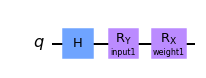

In [3]:
# construct parametrized circuit
params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl")

We create an observable manually. If it is set, then The default observable $Z^{\otimes n}$, where $n$ is the number of qubits, is created automatically.

In [4]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

Construct EstimatorQNN with the observable, input parameters, and weight parameters. We don't set the `estimator` parameter, the network will create an instance of the reference `Estimator` primitive for us.

In [5]:
qnn1 = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)

Traceback (most recent call last):
  Input In [5] in <cell line: 1>
    qnn1 = EstimatorQNN(
NameError: name 'EstimatorQNN' is not defined

Use %tb to get the full traceback.


In [ ]:
# define (random) input and weights
input1 = algorithm_globals.random.random(qnn1.num_inputs)
weights1 = algorithm_globals.random.random(qnn1.num_weights)

In [ ]:
# QNN forward pass
qnn1.forward(input1, weights1)

In [ ]:
# QNN batched forward pass
qnn1.forward([input1, input1], weights1)

In [ ]:
# QNN backward pass
qnn1.backward(input1, weights1)

In [ ]:
# QNN batched backward pass
qnn1.backward([input1, input1], weights1)

Combining multiple observables in a list allows to create more complex QNNs.

In [ ]:
observable2 = SparsePauliOp.from_list([("Z" * qc1.num_qubits, 1)])

qnn2 = EstimatorQNN(
    circuit=qc1,
    observables=[observable1, observable2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
)

In [ ]:
# QNN forward pass
qnn2.forward(input1, weights1)

In [ ]:
# QNN backward pass
qnn2.backward(input1, weights1)

## 4. `SamplerQNN`

The `SamplerQNN` is based on a (parametrized) `QuantumCircuit`.
This can take input as well as weight parameters and produces samples from the measurement. The samples are interpreted as probabilities of measuring the integer index corresponding to a bitstring. Gradients can be estimated efficiently and the `SamplerQNN` provides a backward pass as well.

Further, the `SamplerQNN` allows to specify an `interpret` function to post-process the samples. This is expected to take a measured integer (from a bitstring) and map it to a new index, i.e. non-negative integer. In this case, the output shape needs to be provided and the probabilities are aggregated accordingly.

If no `interpret` function is used, the dimension of the probability vector scales exponentially with the number of qubits. In case of an `interpret` function it depends on the expected outcome. If, for instance, an index is mapped to the parity of the corresponding bitstring, i.e., to 0 or 1, a dense output makes sense and the result will be a probability vector of length 2.

In [ ]:
from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN

In [ ]:
qc = RealAmplitudes(2, entanglement="linear", reps=1)
qc.draw(output="mpl")

As in the previous example, we don't set the `sampler` parameter, the network will create an instance of the reference `Sampler` primitive for us.

In [ ]:
# specify sampler-based QNN
qnn4 = SamplerQNN(circuit=qc, input_params=[], weight_params=qc.parameters)

In [ ]:
# define (random) input and weights
input4 = algorithm_globals.random.random(qnn4.num_inputs)
weights4 = algorithm_globals.random.random(qnn4.num_weights)

In [ ]:
# QNN forward pass
qnn4.forward(input4, weights4)

In [ ]:
# QNN backward pass, returns a tuple of matrices, None for the gradients with respect to input data.
qnn4.backward(input4, weights4)

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright